In [1]:
!pip install pytorch_tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.metrics import roc_curve, auc


In [3]:
# Loading dataset
df = pd.read_csv("heart_disease_uci.csv")
df.drop(columns=["id", "dataset"], inplace=True)
df["target"] = df["num"].apply(lambda x: 1 if x > 0 else 0)
df.drop(columns=["num"], inplace=True)

numerical = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
categorical = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

In [4]:
# Handling missing values and encoding categorical features
df[numerical] = SimpleImputer(strategy="median").fit_transform(df[numerical])
for col in categorical:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))
df[numerical] = StandardScaler().fit_transform(df[numerical])

X = df[numerical + categorical].values
y = df["target"].values

In [5]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# TabNet Classifier
tabnet = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    momentum=0.3,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=0,
    seed=42
)

In [6]:
tabnet.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'val'],
    eval_metric=['accuracy'],
    max_epochs=200,
    patience=20,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


Early stopping occurred at epoch 53 with best_epoch = 33 and best_val_accuracy = 0.83152


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [7]:
# Predictions
y_pred_proba = tabnet.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

In [8]:
# Metrics
results = {
    'Model': "TabNet",
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba)
}

print("\n Final Evaluation Metrics for TabNet:")
for k, v in results.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")


 Final Evaluation Metrics for TabNet:
Model: TabNet
Accuracy: 0.8315
F1 Score: 0.8517
Precision: 0.8318
Recall: 0.8725
ROC AUC: 0.8733


In [9]:
import matplotlib.pyplot as plt

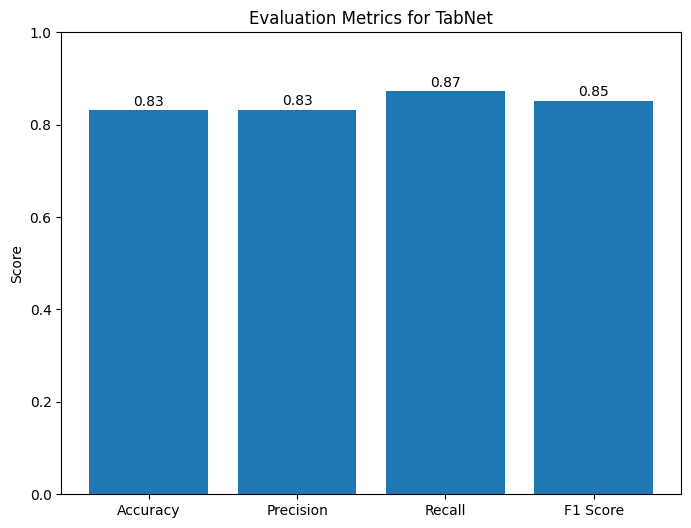

In [10]:
# bar plot
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [results[m] for m in metrics_to_plot]

plt.figure(figsize=(8, 6))
plt.bar(metrics_to_plot, scores)
plt.ylabel("Score")
plt.title("Evaluation Metrics for TabNet")
plt.ylim(0, 1)
for i, v in enumerate(scores):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)
plt.show()


In [11]:
print(tabnet.history)


{'loss': [2.4532782098521357, 0.929909436599068, 0.875175442384637, 0.697170483029407, 0.6802718665288843, 0.6767560191776442, 0.5367364378079124, 0.522400122621785, 0.5099219524342081, 0.5920395877050317, 0.5276923659055129, 0.5025692582130432, 0.5084480202716329, 0.4902825251869533, 0.45624422897463257, 0.45727975990461267, 0.43445225254349085, 0.4362872424332992, 0.40345087777013366, 0.4106170275936956, 0.4067475562510283, 0.41243676258170087, 0.416572075823079, 0.39114161937133124, 0.3933981151684471, 0.4106549711331077, 0.38139555894810223, 0.3797016882378122, 0.3894627612570058, 0.3856390986753547, 0.36661087041315826, 0.3610478833965633, 0.371664179408032, 0.36346577950145886, 0.3613346918769505, 0.35077390463455865, 0.3582947383756223, 0.3572672242703645, 0.3677983037803484, 0.34862256957137067, 0.3493110511613929, 0.32485075489334436, 0.35788060012071027, 0.34521216801975085, 0.36768279386603314, 0.32397001074708026, 0.32349352732948633, 0.33373622661051544, 0.3102488414100978

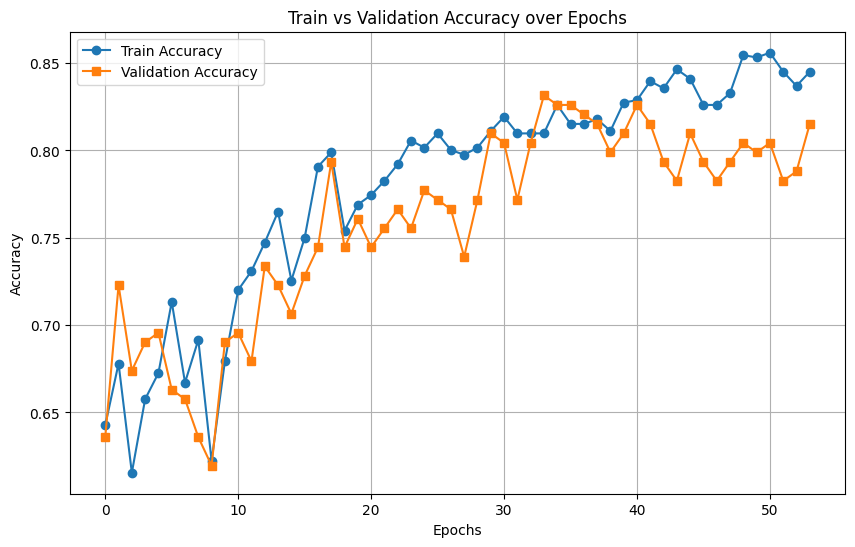

In [12]:
# Extract both train and validation accuracy
train_acc = tabnet.history['train_accuracy']
val_acc = tabnet.history['val_accuracy']

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Train Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

In [14]:
# Defining the regularized TabNet model
tabnet = TabNetClassifier(
    n_d=32, n_a=32,
    n_steps=5,
    gamma=1.5,
    n_independent=2, n_shared=2,
    lambda_sparse=1e-3,         # Regularization
    momentum=0.5,               # Smoothing
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.01),
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    seed=42,
    verbose=0
)

In [15]:
# Fitting model with both train and validation sets to track accuracy
tabnet.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'val'],
    eval_metric=['accuracy'],
    max_epochs=200,
    patience=20,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


Early stopping occurred at epoch 70 with best_epoch = 50 and best_val_accuracy = 0.84239


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [16]:
# Predicting and calculating metrics
y_pred_proba = tabnet.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

results = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba)
}

In [17]:
print("\n Final Evaluation Metrics (Regularized TabNet):")
for k, v in results.items():
    print(f"{k}: {v:.4f}")


 Final Evaluation Metrics (Regularized TabNet):
Accuracy: 0.8424
Precision: 0.8476
Recall: 0.8725
F1 Score: 0.8599
ROC AUC: 0.8920


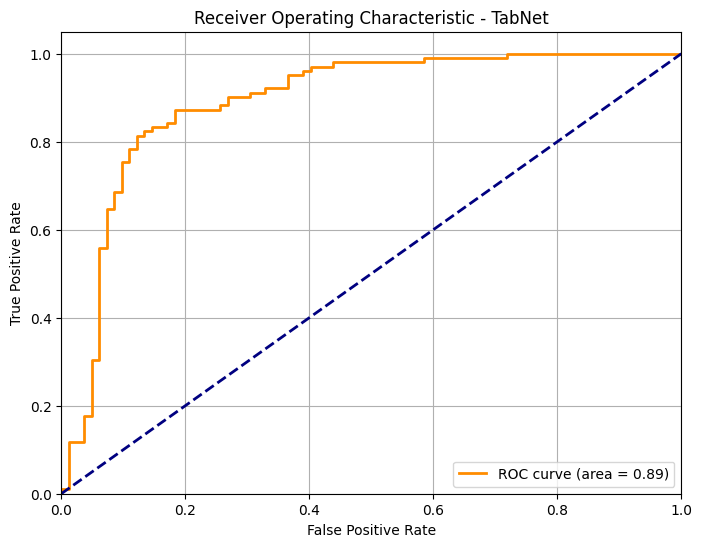

In [18]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - TabNet')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

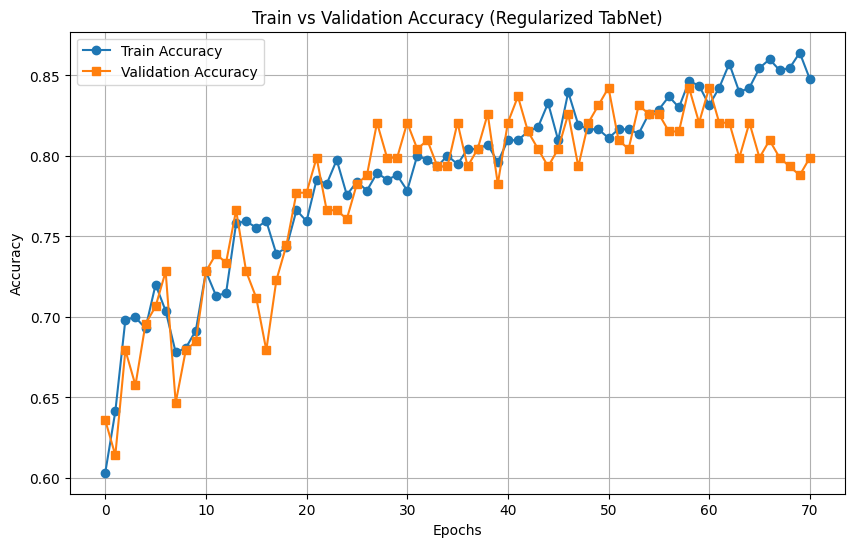

In [19]:
# Accuracy Plot
train_acc = tabnet.history['train_accuracy']
val_acc = tabnet.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Train Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy (Regularized TabNet)")
plt.legend()
plt.grid(True)
plt.show()


  0%|          | 0/184 [00:00<?, ?it/s]

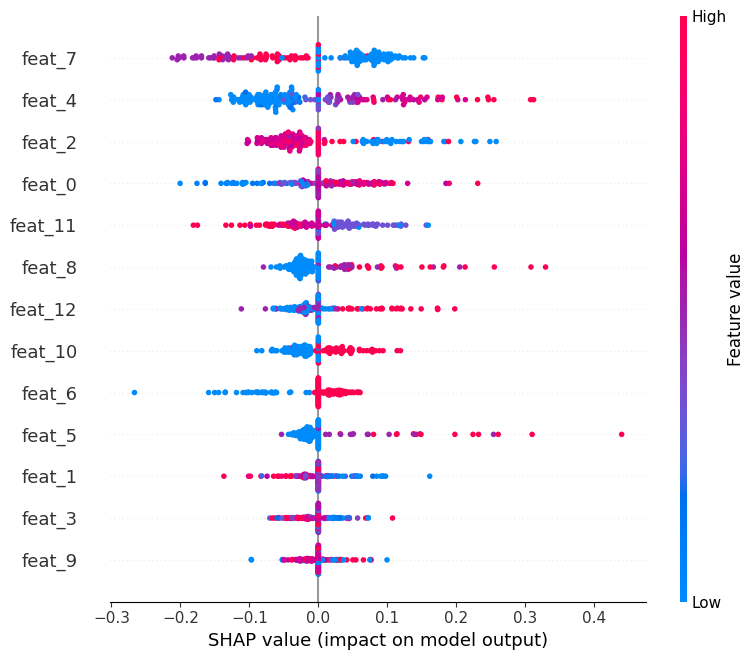

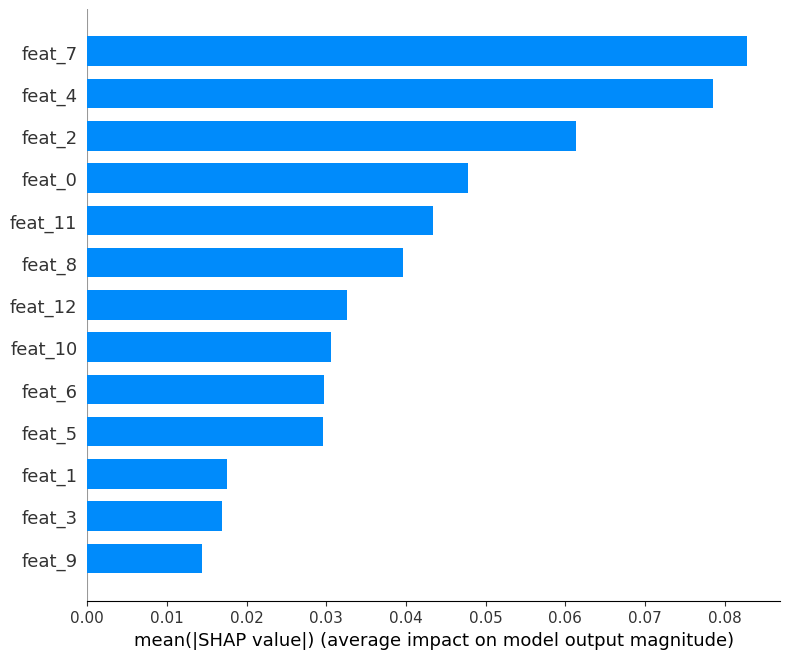

In [20]:
import shap
import pandas as pd
import numpy as np

# SHAP
X_sample = X_test[:200]

# Defining prediction function
predict_fn = lambda x: tabnet.predict_proba(x)[:, 1]
explainer = shap.KernelExplainer(predict_fn, X_train[:100])

# Computing SHAP values
shap_values = explainer.shap_values(X_sample)

# Determining feature names
if isinstance(X, pd.DataFrame):
    feature_names = X.columns
else:
    feature_names = [f'feat_{i}' for i in range(X.shape[1])]

X_sample_df = pd.DataFrame(X_sample, columns=feature_names)

# Summary plot
shap.summary_plot(shap_values, X_sample_df)
shap.summary_plot(shap_values, X_sample_df, plot_type='bar')